# Importing appropriate libraries and modules

In [711]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.pylab import rcParams
import re
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import grangercausalitytests
from stldecompose import decompose, forecast
from stldecompose.forecast_funcs import (naive,
                                         drift, 
                                         mean, 
                                         seasonal_naive)
from pandas import Grouper
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import time
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from fbprophet import Prophet as proph
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
from fbprophet.plot import plot_cross_validation_metric
from sklearn import preprocessing

%matplotlib inline

# SP500 and VIX

"The CBOE Volatility Index, commonly known as the VIX, is calculated from options on the SPX cash index expiring between 23-37 days.. This gives the market’s anticipation of implied volatility (IV) for the next 30 days. When the market makes a larger move down traders look for protection and bid up puts which increases the VIX. Historically, investors have been afraid of a large down move and not a big up move since most investors are long stocks."

# Reading SP500 futures data and VIX
    Source: 
    https://www.investing.com/indices/us-spx-500-futures-historical-data
    
    https://www.macrotrends.net/2603/vix-volatility-index-historical-chart

In [647]:
sp500 = pd.DataFrame(pd.read_csv("S&P500FuturesHistoricalData.csv"))
vix= pd.DataFrame(pd.read_csv("vix-volatility-index.csv"))

In [648]:
sp500.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"May 12, 2017","2,388.75","2,390.25","2,391.50","2,384.25",1.09M,-0.09%
1,"May 11, 2017","2,391.00","2,395.00","2,395.25","2,379.00",1.36M,-0.18%
2,"May 10, 2017","2,395.25","2,391.75","2,397.00","2,387.50",998.86K,0.08%
3,"May 09, 2017","2,393.25","2,394.50","2,400.00","2,388.75",1.11M,-0.07%
4,"May 08, 2017","2,395.00","2,402.50","2,403.75","2,389.75",957.16K,-0.11%


In [649]:
vix.head()

,date,value
0,1990-01-02,17.24
1,1990-01-03,18.19
2,1990-01-04,19.22
3,1990-01-05,20.11
4,1990-01-08,20.26


In [650]:
vix['date']= pd.to_datetime(vix['date'])

In [651]:
vix.head()

,date,value
0,1990-01-02,17.24
1,1990-01-03,18.19
2,1990-01-04,19.22
3,1990-01-05,20.11
4,1990-01-08,20.26


In [652]:
sp500.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')

In [653]:
sp500['Date']= pd.to_datetime(sp500['Date'])

In [654]:
sp500.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2017-05-12,"2,388.75","2,390.25","2,391.50","2,384.25",1.09M,-0.09%
1,2017-05-11,"2,391.00","2,395.00","2,395.25","2,379.00",1.36M,-0.18%
2,2017-05-10,"2,395.25","2,391.75","2,397.00","2,387.50",998.86K,0.08%
3,2017-05-09,"2,393.25","2,394.50","2,400.00","2,388.75",1.11M,-0.07%
4,2017-05-08,"2,395.00","2,402.50","2,403.75","2,389.75",957.16K,-0.11%


In [655]:
sp500.set_index('Date', inplace= True)

In [656]:
vix.set_index('date', inplace= True)

In [657]:
sp500.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2017-05-12,"2,388.75","2,390.25","2,391.50","2,384.25",1.09M,-0.09%
2017-05-11,"2,391.00","2,395.00","2,395.25","2,379.00",1.36M,-0.18%
2017-05-10,"2,395.25","2,391.75","2,397.00","2,387.50",998.86K,0.08%
2017-05-09,"2,393.25","2,394.50","2,400.00","2,388.75",1.11M,-0.07%
2017-05-08,"2,395.00","2,402.50","2,403.75","2,389.75",957.16K,-0.11%


In [658]:
sp500['Price']= sp500['Price'].apply(lambda x: x.replace(',',''))

In [659]:
sp500['Price'] = sp500['Price'].astype('float64')

In [660]:
vix.rename(columns= {'value':'VIX'}, inplace= True)

In [661]:
sp500.rename(columns={'Price':'SP500ClosingPrice'}, inplace=True)

In [662]:
sp500closing= sp500['SP500ClosingPrice']

In [663]:
VIX= vix['VIX']

In [664]:
sp500closing.head()

Date
2017-05-12    2388.75
2017-05-11    2391.00
2017-05-10    2395.25
2017-05-09    2393.25
2017-05-08    2395.00
Name: SP500ClosingPrice, dtype: float64

In [665]:
VIX.head()

date
1990-01-02    17.24
1990-01-03    18.19
1990-01-04    19.22
1990-01-05    20.11
1990-01-08    20.26
Name: VIX, dtype: float64

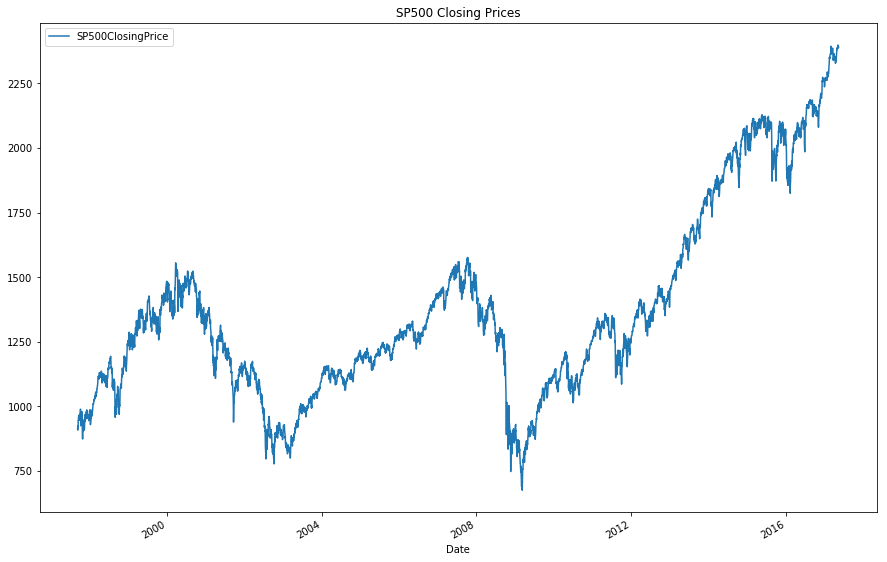

In [667]:
sp500closing.plot(figsize= (15,10))
plt.legend()
plt.title('SP500 Closing Prices')
plt.show();

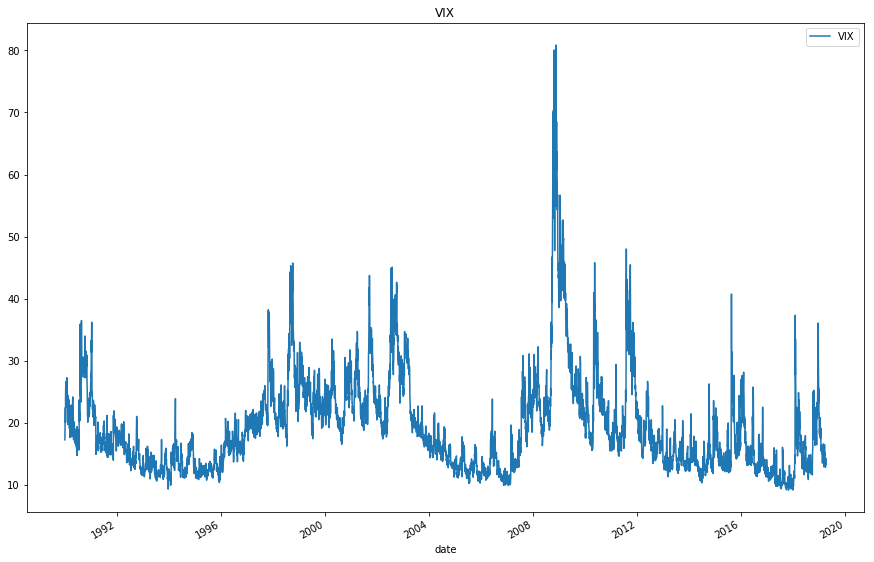

In [668]:
VIX.plot(figsize= (15,10))
plt.legend()
plt.title('VIX')
plt.show();

# Dickey Fuller Test on SP500 & VIX
    Fuller test and observation of chart shows SP500 not stationary. ??Surprise??

In [669]:
print( f" Pvalue for DickeyFuller test of closing prices is {adfuller(sp500closing)[1]} \n Conclusion: Data is not stationary.")

 Pvalue for DickeyFuller test of closing prices is 0.15577734017871037 
 Conclusion: Data is not stationary.


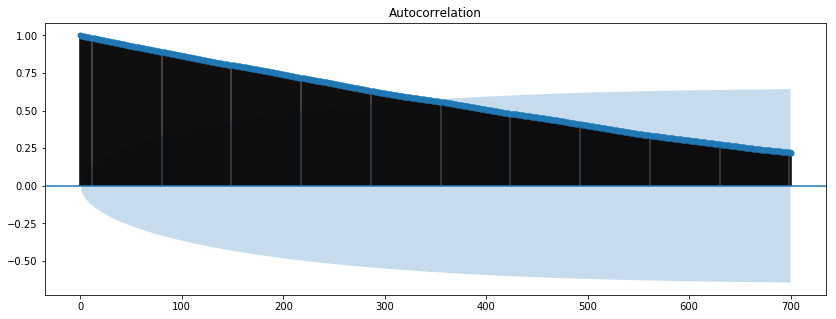

In [437]:
plot_acf(sp500closing, lags=700);

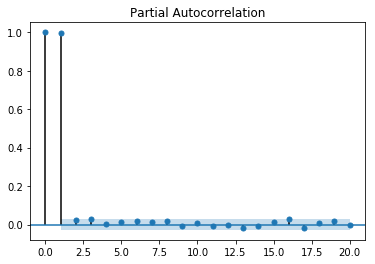

In [670]:
plot_pacf(sp500closing, lags= 20);

In [439]:
lag360daydiff = sp500closing.diff(periods= 360).dropna()

In [472]:
def numofdiffstostionarity(x):    
    counter= 0
    while adfuller(x)[1]>.1:
        x= x.diff(periods= 360).dropna()
        adfuller(x)[1]
        counter +=1
    return counter

In [473]:
numofdiffstostionarity(sp500closing)

2

In [440]:
lag1daydiff = sp500closing.diff(periods= 1).dropna()

In [67]:
lag1daydiff.head()

Date
2017-05-11    2.25
2017-05-10    4.25
2017-05-09   -2.00
2017-05-08    1.75
2017-05-05    2.75
Name: SP500ClosingPrice, dtype: float64

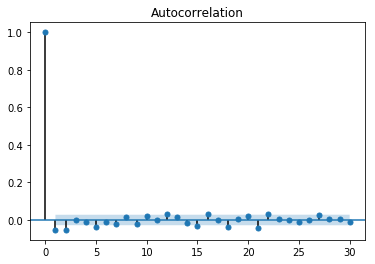

In [68]:
plot_acf(lag1daydiff, lags= 30);

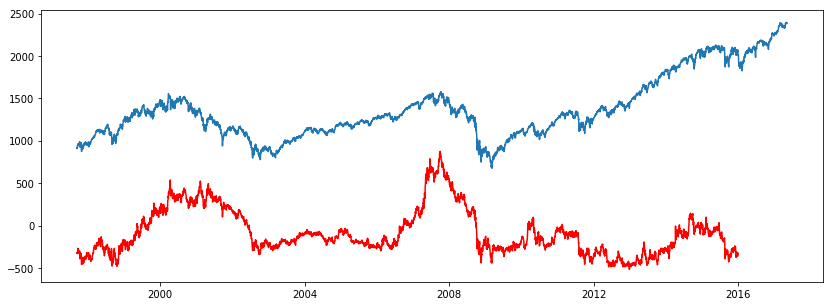

In [443]:
plt.plot(lag360daydiff, color= 'red')
plt.plot(sp500closing)

In [444]:
adfuller(lag360daydiff)

(-2.2809907202165083,
 0.1781721520445188,
 22,
 4616,
 {'1%': -3.431767448052371,
  '5%': -2.8621663472971237,
  '10%': -2.567103407395045},
 41324.071011274595)

In [447]:
print( f" Pvalue for DickeyFuller test of after 360 day diff is {adfuller(lag360daydiff)[1]} \n Conclusion: Data is still not stationary but looking better.")



 Pvalue for DickeyFuller test of after 360 day diff is 0.1781721520445188 
 Conclusion: Data is still not stationary but looking better.


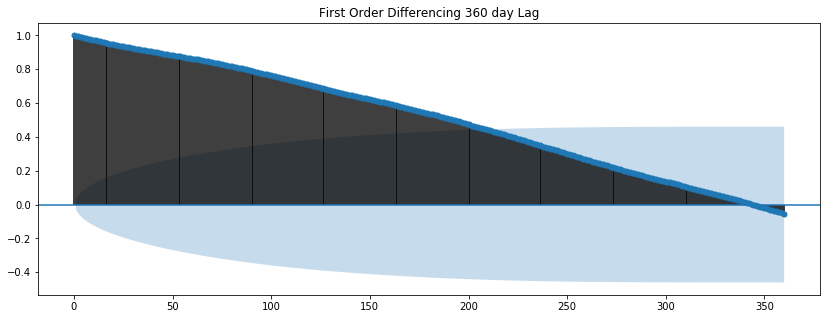

In [465]:
plot_acf(lag360daydiff,lags= 360, title= "First Order Differencing 360 day Lag");

In [500]:
secondOrderlag360daydiff = lag360daydiff.diff(periods= 360).dropna()

In [506]:
secondOrderlag360daydiffminus30mean =SecondOrderlag360daydiff- SecondOrderlag360daydiff.rolling(30).mean()

In [507]:
secondOrderlag360daydiffminus30mean.dropna(inplace= True)

In [509]:
print( f" Pvalue for DickeyFuller test of after Second order 360 day diff minus the mean is {adfuller(secondOrderlag360daydiffminus30mean)[1]} \n Conclusion: Data is stationary .")


 Pvalue for DickeyFuller test of after Second order 360 day diff minus the mean is 3.197412802930967e-17 
 Conclusion: Data is stationary .


In [460]:
thirdOrderlag360daydiff = SecondOrderlag360daydiff.diff(periods= 360).dropna()

In [477]:
print( f" Pvalue for DickeyFuller test of after Second order 360 day diff is {adfuller(thirdOrderlag360daydiff)[1]} \n Conclusion: Data is still not stationary but looking better.")


 Pvalue for DickeyFuller test of after Second order 360 day diff is 0.09058057097993882 
 Conclusion: Data is still not stationary but looking better.


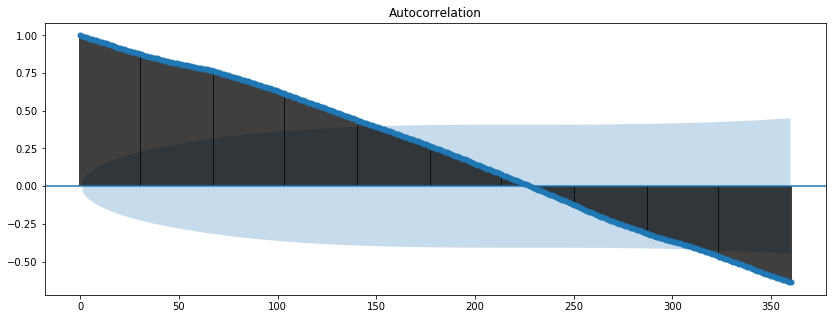

In [466]:
plot_acf(thirdOrderlag360daydiff, lags=360);

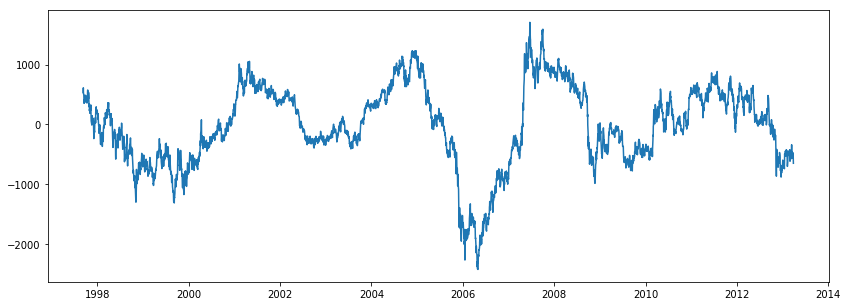

In [474]:
plt.plot(thirdOrderlag360daydiff)

In [478]:
thirdOrderlag360daydiffminus30mean= thirdOrderlag360daydiff- thirdOrderlag360daydiff.rolling(30).mean()

In [481]:
thirdOrderlag360daydiffminus30mean.dropna(inplace=True)

In [482]:
adfuller(thirdOrderlag360daydiffminus30mean)

(-9.308632798810379,
 1.0638314343445182e-15,
 28,
 3861,
 {'1%': -3.4320448077976695,
  '5%': -2.8622888731657667,
  '10%': -2.567168634429352},
 43079.93086199732)

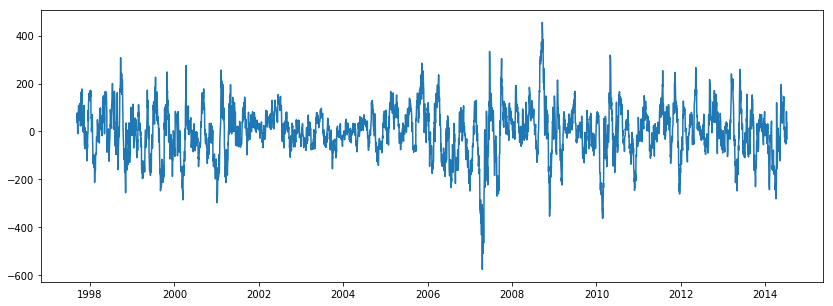

In [510]:
plt.plot(secondOrderlag360daydiffminus30mean);

## VIX is stationary

In [69]:
print( f" Pvalue for DickeyFuller test of VIX is {adfuller(VIX)[1]} \n Conclusion: VIX Data is stationary.")

 Pvalue for DickeyFuller test of VIX is 2.143401700412233e-06 
 Conclusion: VIX Data is stationary.


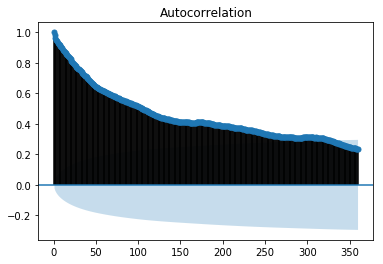

In [70]:
plot_acf(VIX, lags = 360);

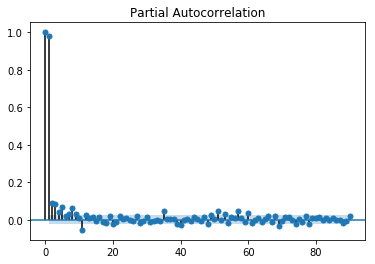

In [71]:
plot_pacf(VIX, lags= 90);

# Moving Averages & Stationarizing SP500 futures data

In [72]:
sp500rollingmean30 = sp500closing.rolling(30).mean()
sp500rollingstd30 = sp500closing.rolling(30).std()

sp500rollingmean30.dropna(inplace= True)
sp500rollingstd30.dropna(inplace= True)

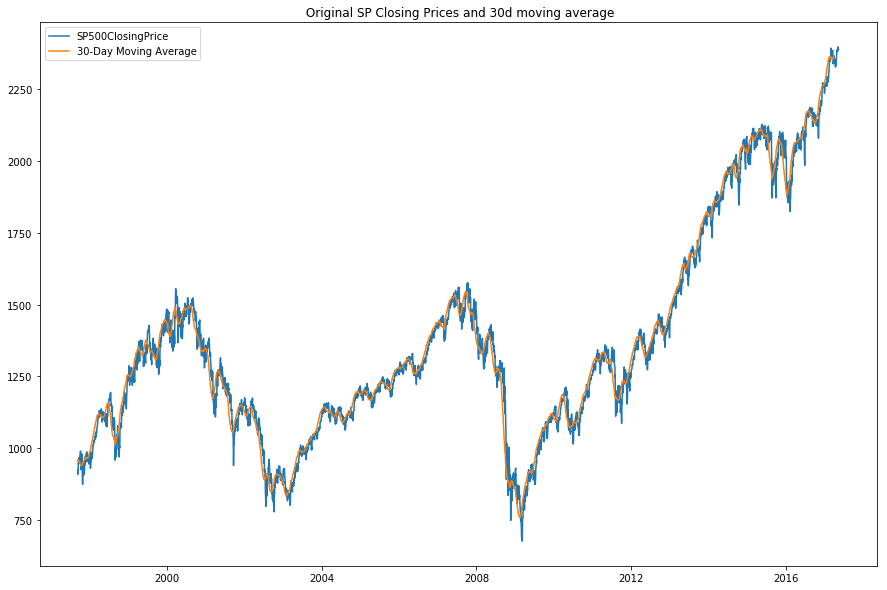

In [73]:
plt.figure(figsize=(15,10))
plt.plot(sp500closing)
plt.plot(sp500rollingmean30, label = '30-Day Moving Average')
plt.legend()
plt.title(" Original SP Closing Prices and 30d moving average")
plt.show();

In [635]:
sp500rollingstd30.index

DatetimeIndex(['2017-03-31', '2017-03-30', '2017-03-29', '2017-03-28',
               '2017-03-27', '2017-03-24', '2017-03-23', '2017-03-22',
               '2017-03-21', '2017-03-20',
               ...
               '1997-09-23', '1997-09-22', '1997-09-19', '1997-09-18',
               '1997-09-17', '1997-09-16', '1997-09-15', '1997-09-12',
               '1997-09-11', '1997-09-10'],
              dtype='datetime64[ns]', name='Date', length=4970, freq=None)

In [638]:
spstdvix= pd.DataFrame(VIX)

In [640]:
spstdvix= spstdvix.join(sp500rollingstd30)

In [641]:
spstdvix.dropna(inplace= True)

In [642]:
spstdvix.head()

,VIX,SP500ClosingPrice
date,,
1997-09-10,24.64,21.409302
1997-09-11,25.99,20.264324
1997-09-12,25.17,18.043786
1997-09-15,25.74,17.046962
1997-09-16,23.77,22.170979


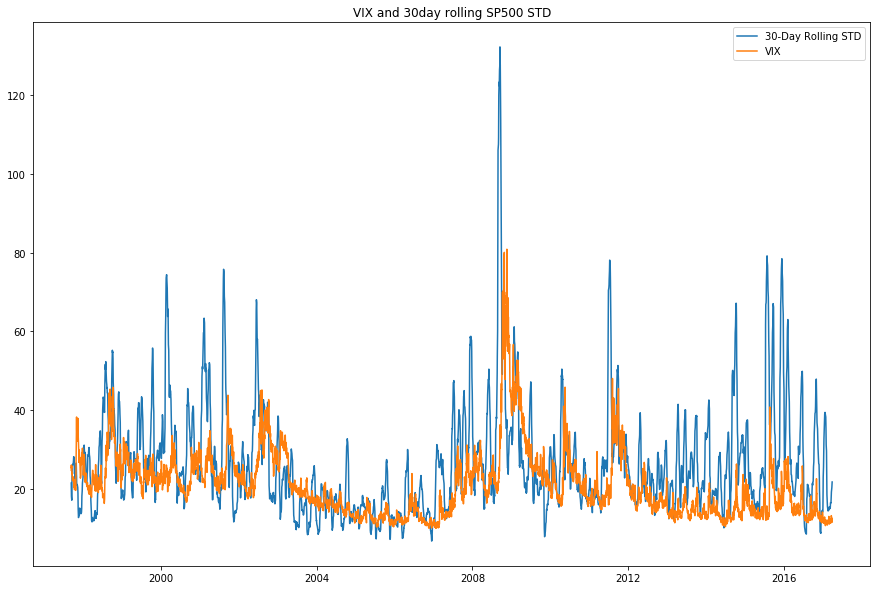

In [644]:
plt.figure(figsize=(15,10))
plt.plot(spstdvix['SP500ClosingPrice'], label = '30-Day Rolling STD')
plt.plot(spstdvix['VIX'], label = 'VIX')
plt.legend()
plt.title("VIX and 30day rolling SP500 STD")
plt.show();

## Transforming the Data

In [75]:
logsp500= np.log(sp500closing)

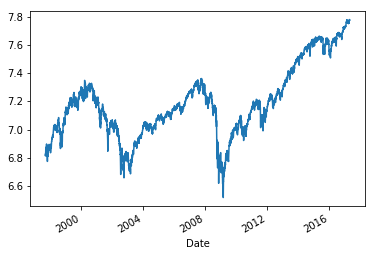

In [76]:
logsp500.plot();

In [77]:
logminusrollingmean = logsp500 - logsp500.rolling(30).mean()

In [78]:
logrollingstd= logsp500.rolling(30).std()

In [79]:
logrollingstd.dropna(inplace= True)

In [80]:
logminusrollingmean.dropna(inplace= True)

In [81]:
print( f" Pvalue for DickeyFuller test of Logdifference SP500 is {adfuller(logminusrollingmean)[1]} \n Conclusion: Data is stationary.")



 Pvalue for DickeyFuller test of Logdifference SP500 is 2.8308457281101394e-21 
 Conclusion: Data is stationary.


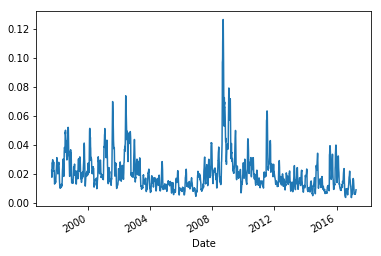

In [82]:
logrollingstd.plot();

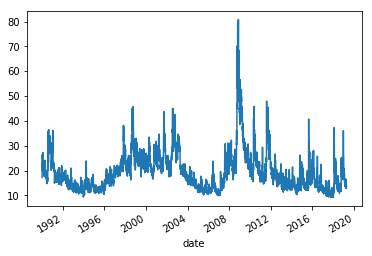

In [83]:
VIX.plot()

!pip install stldecompose

# Decomposition

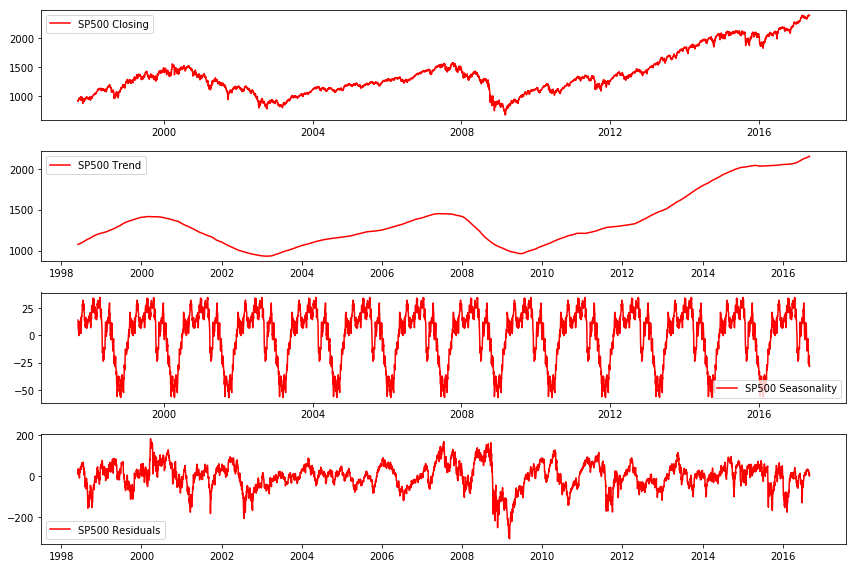

In [680]:
# import seasonal_decompose
decomposition = seasonal_decompose(sp500closing, model= 'additive', freq=365)

# Gather the trend, seasonality and noise of decomposed object
sptrend = decomposition.trend
spseasonal = decomposition.seasonal
spresidual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(sp500closing, label='SP500 Closing', color="red")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(sptrend, label='SP500 Trend', color="red")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(spseasonal,label='SP500 Seasonality', color="red")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(spresidual, label='SP500 Residuals', color="red")
plt.legend(loc='best')
plt.tight_layout()

In [678]:
spdecomposedf= pd.concat({'SP500 Closing': sp500closing ,'SP500 Trend': pd.Series(sptrend), 'SP500 Seasonal' : pd.Series(spseasonal), 'SP500 Residual' :pd.Series(spresidual)}, axis=1).dropna()

In [681]:
spdecomposedf.head()

,SP500 Closing,SP500 Residual,SP500 Seasonal,SP500 Trend
Date,,,,
2016-09-02,2178.00,12.225020,12.743227,2153.031753
2016-09-01,2167.25,0.535779,14.602331,2152.111890
2016-08-31,2169.50,5.054957,13.305756,2151.139288
2016-08-30,2175.25,11.341785,13.810708,2150.097507
2016-08-29,2179.25,19.665313,10.483153,2149.101534


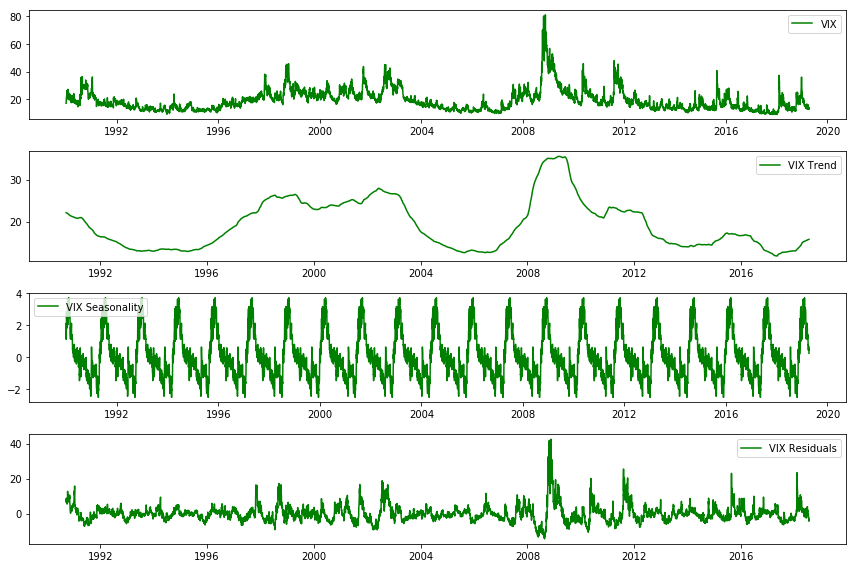

In [691]:
# import seasonal_decompose
decomposition = seasonal_decompose(VIX, model= 'additive', freq=365)

# Gather the trend, seasonality and noise of decomposed object
vixtrend = decomposition.trend
vixseasonal = decomposition.seasonal
vixresidual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(VIX, label='VIX', color="green")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(vixtrend, label='VIX Trend', color="green")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(vixseasonal,label='VIX Seasonality', color="green")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(vixresidual, label='VIX Residuals', color="green")
plt.legend(loc='best')
plt.tight_layout()

In [692]:
vixdecomposedf= pd.concat({'VIX': VIX,'VIX Trend': pd.Series(vixtrend), 'VIX Seasonal' : pd.Series(vixseasonal), 'VIX Residual' :pd.Series(vixresidual)}, axis=1).dropna()




## Looking at the DataFrames

In [693]:
spdecomposedf.head()

,SP500 Closing,SP500 Residual,SP500 Seasonal,SP500 Trend
Date,,,,
2016-09-02,2178.00,12.225020,12.743227,2153.031753
2016-09-01,2167.25,0.535779,14.602331,2152.111890
2016-08-31,2169.50,5.054957,13.305756,2151.139288
2016-08-30,2175.25,11.341785,13.810708,2150.097507
2016-08-29,2179.25,19.665313,10.483153,2149.101534


In [694]:
vixdecomposedf.head()

,VIX,VIX Residual,VIX Seasonal,VIX Trend
date,,,,
1990-09-20,28.66,6.901244,-0.368860,22.127616
1990-09-21,30.04,8.088733,-0.175664,22.126932
1990-09-24,30.56,8.846400,-0.407277,22.120877
1990-09-25,28.81,6.873841,-0.174526,22.110685
1990-09-26,28.19,6.444945,-0.354754,22.099808


In [695]:
combined = spdecomposedf.join([vixdecomposedf, sp500closing])

In [687]:
combined.dropna(inplace= True)

In [689]:
combined.head()

,SP500 Closing,SP500 Residual,SP500 Seasonal,SP500 Trend,VIX,VIX Residual,VIX Seasonal,VIX Trend,SP500ClosingPrice
Date,,,,,,,,,
2016-09-02,2178.00,12.225020,12.743227,2153.031753,11.98,-1.592318,-1.241928,14.814247,2178.00
2016-09-01,2167.25,0.535779,14.602331,2152.111890,13.48,-0.150070,-1.223628,14.853699,2167.25
2016-08-31,2169.50,5.054957,13.305756,2151.139288,13.42,-0.673902,-0.785331,14.879233,2169.50
2016-08-30,2175.25,11.341785,13.810708,2150.097507,13.12,-1.234382,-0.549207,14.903589,2175.25
2016-08-29,2179.25,19.665313,10.483153,2149.101534,12.94,-1.700140,-0.281723,14.921863,2179.25


## Granger Causality

The Null hypothesis for grangercausalitytests is that the time series in the second column, x2, does NOT Granger cause the time series in the first column, x1. Grange causality means that past values of x2 have a statistically significant effect on the current value of x1, taking past values of x1 into account as regressors. We reject the null hypothesis that x2 does not Granger cause x1 if the pvalues are below a desired size of the test.

In [696]:
print(grangercausalitytests(combined[['VIX','SP500 Closing']].dropna(),1))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.6926 , p=0.0011  , df_denom=4592, df_num=1
ssr based chi2 test:   chi2=10.6996 , p=0.0011  , df=1
likelihood ratio test: chi2=10.6871 , p=0.0011  , df=1
parameter F test:         F=10.6926 , p=0.0011  , df_denom=4592, df_num=1
{1: ({'ssr_ftest': (10.692586368429994, 0.0010835897025001091, 4592.0, 1), 'ssr_chi2test': (10.699571943148046, 0.0010716032565994643, 1), 'lrtest': (10.687134137355315, 0.0010788320468650796, 1), 'params_ftest': (10.692586368429792, 0.0010835897025001091, 4592.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x1c3bd7afd0>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x1c3bd7a9e8>, array([[0., 1., 0.]])])}


>####  Reject null hypothesis. Stationarized SP500 does cause VIX... Duh makes sense!

## Experiment VIX @ (t-30) with SP @ (t)

In [697]:
combined['VIX30dshift']= combined['VIX'].shift(periods=30)

In [700]:
combined.dropna(inplace= True)

In [701]:
VIXSPshift = combined[['VIX30dshift','SP500 Closing']]

In [704]:
VIXSPshift.head()

,VIX30dshift,SP500 Closing
Date,,
2016-07-22,11.98,2167.50
2016-07-21,13.48,2158.00
2016-07-20,13.42,2167.50
2016-07-19,13.12,2158.75
2016-07-18,12.94,2160.00


In [706]:
print(grangercausalitytests(VIXSPshift[['SP500 Closing','VIX30dshift']].dropna(),1))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.8498 , p=0.0002  , df_denom=4524, df_num=1
ssr based chi2 test:   chi2=13.8590 , p=0.0002  , df=1
likelihood ratio test: chi2=13.8378 , p=0.0002  , df=1
parameter F test:         F=13.8498 , p=0.0002  , df_denom=4524, df_num=1
{1: ({'ssr_ftest': (13.849782037642138, 0.00020042473785739114, 4524.0, 1), 'ssr_chi2test': (13.858966243237392, 0.00019705427666720114, 1), 'lrtest': (13.837795507766714, 0.00019928687792513728, 1), 'params_ftest': (13.84978203763648, 0.00020042473785804944, 4524.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x1c3bd7abe0>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x1c3bd90da0>, array([[0., 1., 0.]])])}


## Tried a function to find a sweet spot... what we found is that there is a strong causal relationship regardless of many shifts back we take

def shifter(vs, counter = 0):
    while grangercausalitytests(vs[['Log SP500 minus Log 30MA','VIX']].dropna(),1, verbose= False )[1][0]['ssr_ftest'][1] < 0.000001:
        vs['VIX'] = vs['VIX'].shift(1)
        vs['VIX'] = vs['VIX'].dropna(inplace= True)
        counter += 1
    return vs, counter
vs, counter= shifter(VIXSPshift)
print(counter)






# ARIMA Model SP500

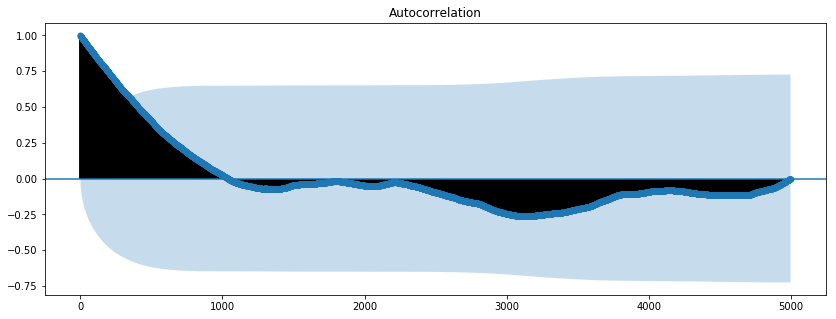

In [709]:
rcParams['figure.figsize']= 14,5
plot_acf(sp500closing);

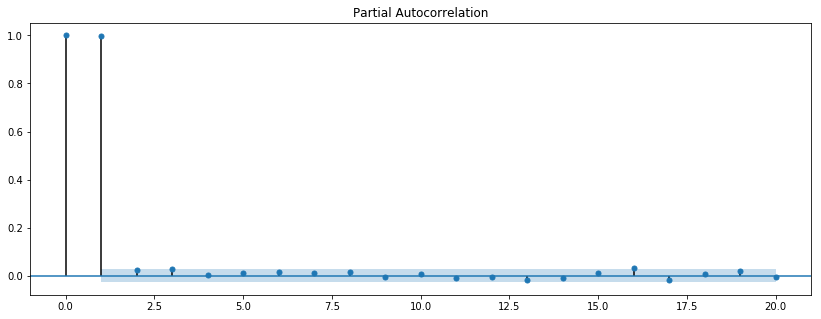

In [710]:
rcParams['figure.figsize']= 14,5
plot_pacf(sp500closing, lags=20);

> ## One or two day lag should be used as our p when fitting ARIMA model

In [716]:
series.describe()

count    4537.000000
mean        0.427945
std         0.084765
min         0.000000
25%         0.379866
50%         0.417537
75%         0.469587
max         1.000000
Name: Standardized_LogSP, dtype: float64

In [717]:
exogVIX30shift.describe()

count    4537.000000
mean        0.157105
std         0.122264
min         0.000000
25%         0.067352
50%         0.133296
75%         0.210511
max         1.000000
Name: Standardized_VIXtminus30, dtype: float64

In [718]:
series = VIXSPshift['SP500 Closing'].values #returns a numpy array

In [344]:
series

array([-5.22501994e-06,  9.37402350e-03,  1.17813678e-02, ...,
       -3.49313622e-02, -4.95325088e-02, -3.08649021e-02])

In [347]:
VIXSPshift.tail()

,VIXtminus30,Log SP500 minus Log 30MA
Date,,
1998-06-08,20.10,-0.022535
1998-06-05,17.34,-0.019895
1998-06-04,16.23,-0.034931
1998-06-03,16.97,-0.049533
1998-06-02,17.89,-0.030865


In [719]:
# Normalize total_bedrooms column
SP_array = np.array(VIXSPshift['SP500 Closing'])
VIXtminus30_array = np.array(VIXSPshift['VIX30dshift'])

min_max_scalersp = preprocessing.MinMaxScaler()
SP_scaled = min_max_scalersp.fit_transform(SP_array.reshape(-1, 1))

min_max_scalerVIX = preprocessing.MinMaxScaler()
VIX_scaled = min_max_scalerVIX.fit_transform(VIXtminus30_array.reshape(-1, 1))

# normalized_Log = preprocessing.normalize([LogSP_array])
# normalized_VIX = preprocessing.normalize([VIXtminus30_array])

In [720]:
# VIXSPshift['normalized_SP']= normalized_SP.flatten()
# VIXSPshift['normalized_VIX']= normalized_VIX.flatten()

VIXSPshift['Standardized_SP']= SP_scaled.flatten()
VIXSPshift['Standardized_VIXtminus30']= VIX_scaled.flatten()


In [722]:
VIXSPshift.head()

,VIX30dshift,SP500 Closing,Standardized_SP,Standardized_VIXtminus30
Date,,,,
2016-07-22,11.98,2167.50,1.000000,0.029449
2016-07-21,13.48,2158.00,0.993631,0.050585
2016-07-20,13.42,2167.50,1.000000,0.049739
2016-07-19,13.12,2158.75,0.994133,0.045512
2016-07-18,12.94,2160.00,0.994972,0.042976


VIXSPshift= VIXSPshift.join(secondOrderlag360daydiffminus30mean, rsuffix= 'secondorder')

In [723]:
VIXSPshift.dropna(inplace= True)

# More like it! After transforming and Standardizing Data

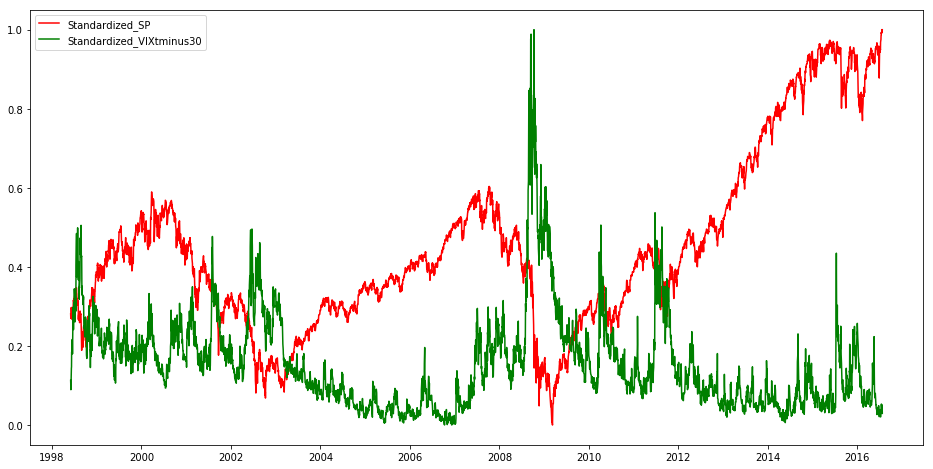

In [728]:
plt.figure(figsize=(16,8))
plt.plot(VIXSPshift['Standardized_SP'], color= 'red')
plt.plot(VIXSPshift['Standardized_VIXtminus30'], color= 'green')
plt.legend()
plt.show();

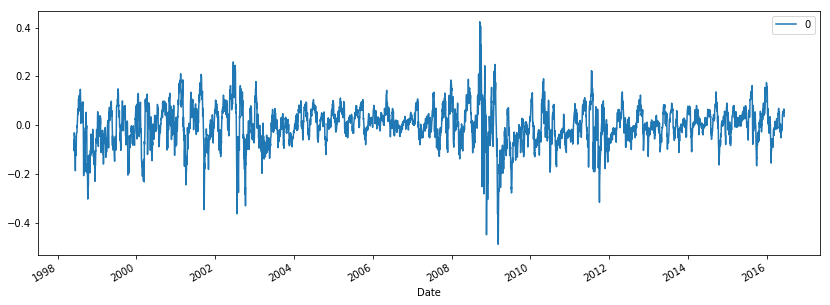

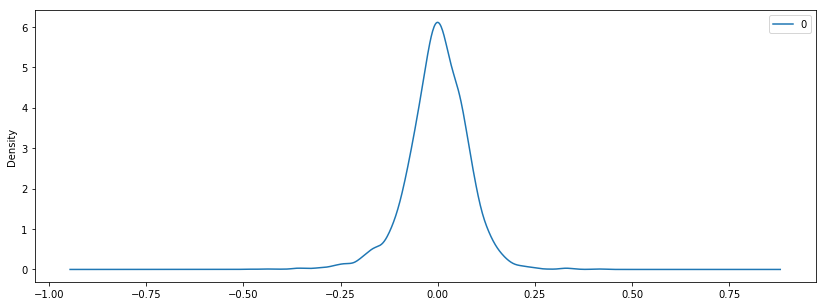

                  0
count  4.537000e+03
mean   5.945573e-10
std    7.808599e-02
min   -4.891397e-01
25%   -4.174944e-02
50%    2.627358e-03
75%    4.831181e-02
max    4.243909e-01


In [526]:
series= VIXSPshift['Standardized_LogSP']
exogVIX30shift= VIXSPshift['Standardized_VIXtminus30']
model = ARIMA(endog=series, exog=exogVIX30shift, order=(0,0,0))
model_fit = model.fit(disp=0)
#print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [603]:
X1 = series.values
X2= exogVIX30shift.values
size = int(len(X1) * 0.9)
compsize= int(len(X1) * 0.1)
trainEndo, testEndo = X1[0:size], X1[size:]
trainExog, testExog = X2[0:size], X2[size:]


In [604]:
# define a new variable using train, but they're not the same variable
historyEndo = [x for x in trainEndo]
historyExog = [x for x in trainExog]

In [605]:
len(historyEndo)

4083

In [606]:
len(historyExog)

4083

model = ARIMA(endog=trainEndo, exog=trainExog, order=(0,0,0))
model_fit = model.fit(disp=0)
output = model_fit.forecast(steps= len(testEndo), exog= testExog)
yhat = output
# predictions.append(yhat)
# obs = testEndo[t]
# historyEndo.append(obs)

In [607]:
print(len(historyEndo),len(historyExog), len(testEndo), len(testExog))

4083 4083 454 454


In [619]:
#instantiate empty list
predictions = list()

for t in range(len(testEndo)):
    model = ARIMA(endog=historyEndo, order=(0,0,0))
#     , exog=historyExog
    model_fit = model.fit(disp=0)
    output = model_fit.forecast(steps=1)
#     exog= np.array(testExog[t:t+1]
    yhat = output[0]
    predictions.append(yhat)
    obs = testEndo[t]
#     obsexog = testExog[t]
    historyEndo.append(obs)
#     historyExog.append(obsexog)

In [620]:
np.array(testExog[t:t+1]).shape

(1,)

In [621]:
len(predictions)

454

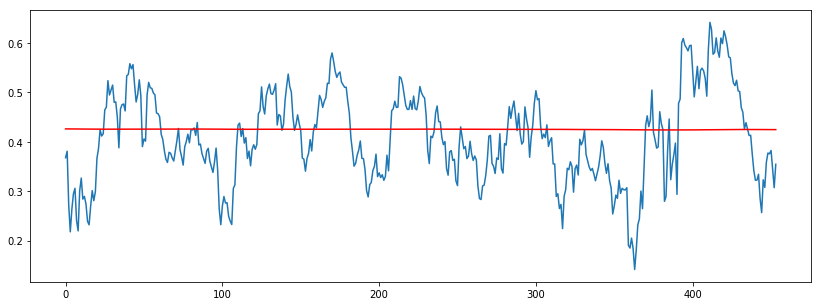

In [622]:
#     print('predicted=%f, expected=%f' % (yhat, obs))
# error = mean_squared_error(testEndo, predictions)
# print('Test MSE: %.9f' % error)
# plot
plt.plot(testEndo)
plt.plot(predictions, color='red')
plt.show()

In [618]:
error = mean_squared_error(testEndo, predictions)
print(error)

0.0012624987296242596


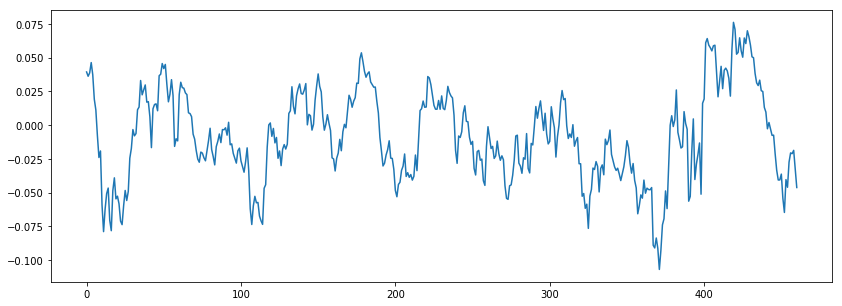

In [253]:
plt.plot(predictions)

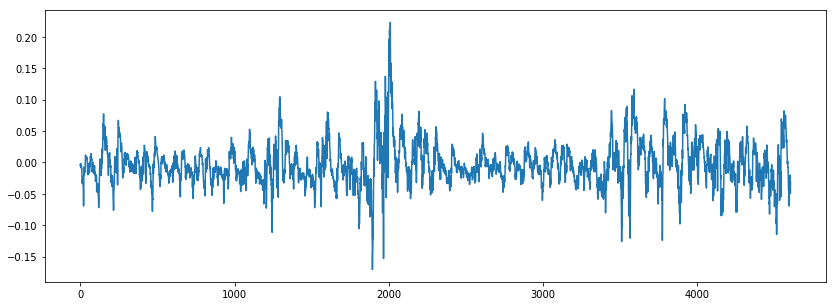

In [254]:
plt.plot(X)

In [255]:
print(X[:size].size)
print(X[size:].size)

4145
461


In [256]:
history = [x for x in train]

In [257]:
len(history)

4145

In [258]:
train = X[0:size]
test = X[size:]

In [259]:
len(train), len(test)

(4145, 461)

# FBProphet Forecasting Model

In [624]:
Model = proph(interval_width=0.95, daily_seasonality= True)

In [625]:
spprophet = sp500closing.reset_index()

In [628]:
spprophet.head()

,ds,y
0,2017-05-12,2388.75
1,2017-05-11,2391.00
2,2017-05-10,2395.25
3,2017-05-09,2393.25
4,2017-05-08,2395.00


In [627]:
spprophet = spprophet.rename(columns={'Date': 'ds',
                        'SP500ClosingPrice' : 'y'})

In [316]:
Model.fit(spprophet);

In [321]:
future_dates = Model.make_future_dataframe(periods=36, freq='D', include_history= True)
future_dates.tail()

,ds
5030,2017-06-13
5031,2017-06-14
5032,2017-06-15
5033,2017-06-16
5034,2017-06-17


In [332]:
forecast = Model.predict(future_dates)

In [335]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
5030,2017-06-13,2281.500606,2203.481880,2423.950676,2278.965314,2289.584212,30.381889,30.381889,30.381889,15.271341,...,5.028893,5.028893,5.028893,10.081656,10.081656,10.081656,0.0,0.0,0.0,2311.882495
5031,2017-06-14,2281.897328,2195.738401,2419.236716,2279.255982,2290.408211,29.548030,29.548030,29.548030,15.271341,...,5.042456,5.042456,5.042456,9.234233,9.234233,9.234233,0.0,0.0,0.0,2311.445358
5032,2017-06-15,2282.294050,2198.780234,2435.779895,2279.446388,2291.221509,29.277691,29.277691,29.277691,15.271341,...,5.650851,5.650851,5.650851,8.355500,8.355500,8.355500,0.0,0.0,0.0,2311.571741
5033,2017-06-16,2282.690772,2201.515200,2425.545579,2279.524015,2292.595236,28.046806,28.046806,28.046806,15.271341,...,5.313802,5.313802,5.313802,7.461663,7.461663,7.461663,0.0,0.0,0.0,2310.737578
5034,2017-06-17,2283.087494,2189.254938,2406.138231,2279.601642,2293.378515,19.932255,19.932255,19.932255,15.271341,...,-1.908916,-1.908916,-1.908916,6.569830,6.569830,6.569830,0.0,0.0,0.0,2303.019749


In [328]:
sp500closing.head()

Date
2017-05-12    2388.75
2017-05-11    2391.00
2017-05-10    2395.25
2017-05-09    2393.25
2017-05-08    2395.00
Name: SP500ClosingPrice, dtype: float64

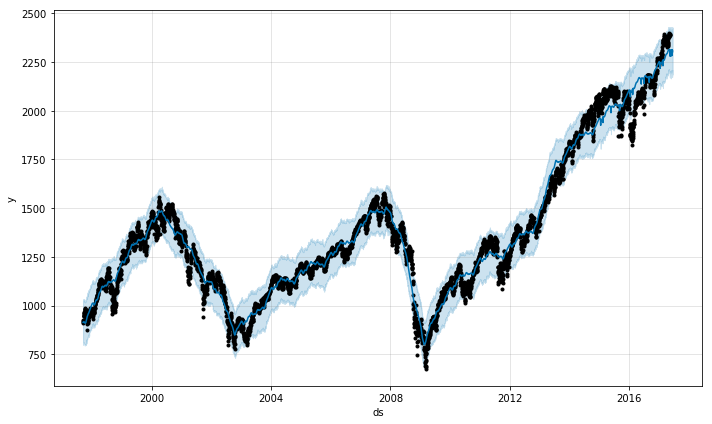

In [323]:
Model.plot(forecast, uncertainty=True)
plt.show()

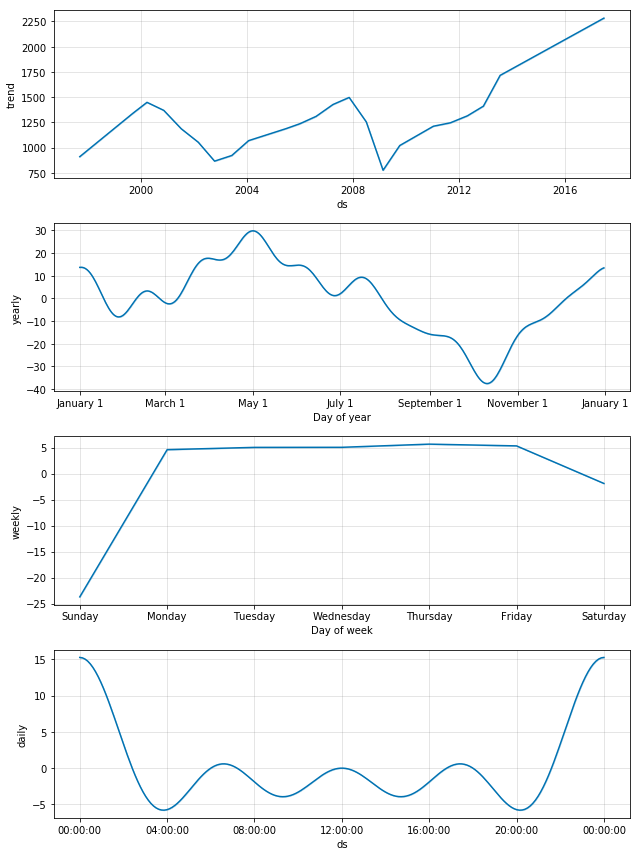

In [324]:
Model.plot_components(forecast)
plt.show()

In [338]:
df_cv = cross_validation(Model, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head()

INFO:fbprophet.diagnostics:Making 34 forecasts with cutoffs between 2000-02-06 00:00:00 and 2016-05-12 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2000-02-07,1452.833419,1408.697786,1500.386973,1427.25,2000-02-06
1,2000-02-08,1454.007215,1409.512992,1501.115646,1446.25,2000-02-06
2,2000-02-09,1455.454925,1408.333771,1498.339881,1418.25,2000-02-06
3,2000-02-10,1455.904910,1410.047734,1505.204641,1419.25,2000-02-06
4,2000-02-11,1458.838941,1412.959684,1500.485548,1396.75,2000-02-06


In [340]:
perfmet = performance_metrics(df_cv)

In [342]:
perfmet.head()

,horizon,mse,rmse,mae,mape,coverage
4549,37 days,17450.005966,132.098471,99.495414,0.078989,0.552723
1780,37 days,17483.254136,132.224257,99.664277,0.079168,0.551564
6829,37 days,17486.547427,132.236710,99.682531,0.079191,0.551564
7609,37 days,17463.134267,132.148153,99.580086,0.079128,0.552723
1527,37 days,17445.709493,132.082207,99.443588,0.079049,0.553882


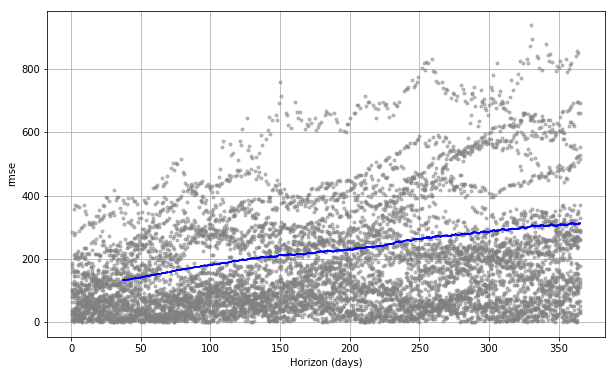

In [346]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')

# Running LSTM - RNN Model on VIX

### Preparing the data

In [4]:
#converts series matrix like 
def convertSeriesToMatrix(vectorSeries, sequence_length):
    matrix=[]
    for i in range(len(vectorSeries)-sequence_length+1):
        matrix.append(vectorSeries[i:i+sequence_length])
    return matrix
        

In [5]:
path_to_dataset = 'vix-volatility-index.csv'
sequence_length = 30

In [6]:
vector_vix = []
with open(path_to_dataset) as f:
    next(f) # skip the header row
    for line in f:
        fields = line.split(',')
        vector_vix.append(float(fields[1]))

In [7]:
len(vector_vix)

7373

In [8]:
matrix_vix = convertSeriesToMatrix(vector_vix, sequence_length)

In [9]:
matrix_vix

[[17.24,
  18.19,
  19.22,
  20.11,
  20.26,
  22.2,
  22.44,
  20.05,
  24.64,
  26.34,
  24.18,
  24.16,
  24.34,
  22.5,
  26.7,
  24.72,
  25.39,
  25.63,
  26.28,
  26.44,
  27.25,
  25.36,
  24.87,
  24.32,
  24.54,
  24.69,
  24.29,
  23.77,
  23.69,
  24.38],
 [18.19,
  19.22,
  20.11,
  20.26,
  22.2,
  22.44,
  20.05,
  24.64,
  26.34,
  24.18,
  24.16,
  24.34,
  22.5,
  26.7,
  24.72,
  25.39,
  25.63,
  26.28,
  26.44,
  27.25,
  25.36,
  24.87,
  24.32,
  24.54,
  24.69,
  24.29,
  23.77,
  23.69,
  24.38,
  23.76],
 [19.22,
  20.11,
  20.26,
  22.2,
  22.44,
  20.05,
  24.64,
  26.34,
  24.18,
  24.16,
  24.34,
  22.5,
  26.7,
  24.72,
  25.39,
  25.63,
  26.28,
  26.44,
  27.25,
  25.36,
  24.87,
  24.32,
  24.54,
  24.69,
  24.29,
  23.77,
  23.69,
  24.38,
  23.76,
  22.05],
 [20.11,
  20.26,
  22.2,
  22.44,
  20.05,
  24.64,
  26.34,
  24.18,
  24.16,
  24.34,
  22.5,
  26.7,
  24.72,
  25.39,
  25.63,
  26.28,
  26.44,
  27.25,
  25.36,
  24.87,
  24.32,
  24.54,
 

In [10]:
matrix_vix = np.array(matrix_vix)
shifted_value = matrix_vix.mean()
matrix_vix -= shifted_value
print("Data  shape: ", matrix_vix.shape)

Data  shape:  (7344, 30)


In [11]:
train_row = int(round(0.9 * matrix_vix.shape[0]))
train_set = matrix_vix[:train_row, :]

In [12]:
train_set.shape

(6610, 30)

In [13]:
np.random.seed(1234)

np.random.shuffle(train_set)
# the training set
X_train = train_set[:, :-1]
# the last column is the true value to compute the mean-squared-error loss
y_train = train_set[:, -1] 
# the test set
X_test = matrix_vix[train_row:, :-1]
y_test = matrix_vix[train_row:, -1]

In [14]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Building the Model

In [15]:
model= Sequential()

#layer1: LSTM
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(.2))

#layer 2: LSTM
model.add(LSTM(units=100, return_sequences= False))
model.add(Dropout(.2))

#layer 3: dense
#linear activation: a(x)=x
model.add(Dense(units=1, activation="linear"))

#compile the model
model.compile(loss= "mse", optimizer= "rmsprop")

In [39]:
model.fit(X_train, y_train, batch_size=512, nb_epoch=50, validation_split=0.05, verbose=1)

# save model to single file
# model.save('VIXrnn.h5')

/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


Train on 6279 samples, validate on 331 samples
Epoch 1/50
6279/6279 [==============================] - 4s 589us/step - loss: 33.2288 - val_loss: 22.2805
Epoch 2/50
6279/6279 [==============================] - 2s 383us/step - loss: 17.3154 - val_loss: 17.5150
Epoch 3/50
6279/6279 [==============================] - 2s 390us/step - loss: 14.1465 - val_loss: 16.5631
Epoch 4/50
6279/6279 [==============================] - 2s 382us/step - loss: 12.0583 - val_loss: 14.0278
Epoch 5/50
6279/6279 [==============================] - 2s 384us/step - loss: 10.6942 - val_loss: 12.3396
Epoch 6/50
6279/6279 [==============================] - 2s 383us/step - loss: 9.6640 - val_loss: 11.4286
Epoch 7/50
6279/6279 [==============================] - 2s 383us/step - loss: 8.8103 - val_loss: 10.6059
Epoch 8/50
6279/6279 [==============================] - 2s 391us/step - loss: 8.0790 - val_loss: 10.0546
Epoch 9/50
6279/6279 [==============================] - 3s 402us/step - loss: 7.5246 - val_loss: 10.2306
Epo

In [16]:
test_mse = model.evaluate(X_test, y_test, verbose=1)
print('\nThe mean squared error (MSE) on the test data set is %.3f over %d test samples.' % (test_mse, len(y_test)))

/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


734/734 [==============================] - 1s 883us/step

The mean squared error (MSE) on the test data set is 40.838 over 734 test samples.


In [21]:
predicted_values = model.predict(X_test)
num_test_samples = len(predicted_values)
predicted_values = np.reshape(predicted_values, (num_test_samples,1))

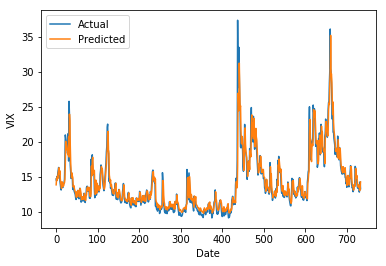

In [22]:
# fig = plt.figure()
actual, = plt.plot(y_test + shifted_value, label= 'Actual')
predicted, = plt.plot(predicted_values + shifted_value, label = 'Predicted')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.legend()
# plt.savefig('VIX output_prediction.jpg', bbox_inches='tight')
plt.show()


In [19]:
from keras.models import load_model
# load model from single file
model = load_model('VIXrnn.h5')
# make predictions
yhat = model.predict(X_test, verbose=0)
print(yhat)

/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


[[-5.39189   ]
 [-4.4771247 ]
 [-4.7528167 ]
 [-4.1763034 ]
 [-4.4831786 ]
 [-3.6861312 ]
 [-3.3345902 ]
 [-2.964029  ]
 [-3.8925607 ]
 [-3.3962834 ]
 [-4.587761  ]
 [-5.116812  ]
 [-5.590088  ]
 [-5.902568  ]
 [-4.969536  ]
 [-4.9976583 ]
 [-5.47013   ]
 [-5.619045  ]
 [-5.48109   ]
 [-5.1428556 ]
 [-5.11646   ]
 [-4.607702  ]
 [-2.530237  ]
 [ 0.8073644 ]
 [ 0.57603216]
 [ 0.20699333]
 [-0.38164455]
 [-0.31061876]
 [-1.1133904 ]
 [-1.0236917 ]
 [ 1.4448471 ]
 [-1.4227607 ]
 [ 4.6878686 ]
 [ 3.746924  ]
 [ 0.12712936]
 [-2.2617755 ]
 [-3.5614877 ]
 [-4.401979  ]
 [-3.706358  ]
 [-4.1392903 ]
 [-4.324968  ]
 [-5.682428  ]
 [-5.4970512 ]
 [-5.5285187 ]
 [-5.9919233 ]
 [-6.201542  ]
 [-6.3595796 ]
 [-6.5824733 ]
 [-6.9956293 ]
 [-7.176441  ]
 [-6.381456  ]
 [-7.0453978 ]
 [-6.29389   ]
 [-6.1910367 ]
 [-6.3565626 ]
 [-6.4320045 ]
 [-7.1284437 ]
 [-6.6509233 ]
 [-5.9138217 ]
 [-6.3534117 ]
 [-6.684232  ]
 [-7.5054355 ]
 [-7.4331217 ]
 [-7.3674417 ]
 [-7.0787663 ]
 [-7.3848224 ]
 [-7.46926

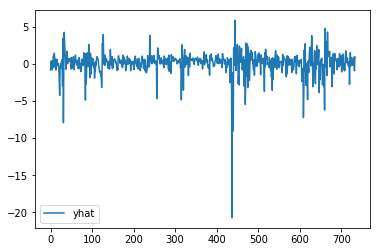

In [31]:
diff= []

for i in range(len(yhat)):
    diff.append(yhat[i]-y_test[i])
    
plt.plot(diff, label= "yhat")
plt.legend()
plt.show();

In [35]:
X_test.shape

(734, 29, 1)

In [36]:
X_test[0,:,:]

array([[-5.29873125],
       [-6.14873125],
       [-5.12873125],
       [-3.82873125],
       [-5.15873125],
       [-3.08873125],
       [-3.88873125],
       [-2.98873125],
       [-4.39873125],
       [-5.40873125],
       [-5.52873125],
       [-5.62873125],
       [-5.89873125],
       [-6.00873125],
       [-5.96873125],
       [-5.29873125],
       [-6.02873125],
       [-5.16873125],
       [-5.28873125],
       [-5.47873125],
       [-4.02873125],
       [-3.54873125],
       [-4.56873125],
       [-3.64873125],
       [-3.19873125],
       [-3.33873125],
       [-4.52873125],
       [-4.67873125],
       [-5.61873125]])

In [40]:
y_pred_test_lstm = model.predict(X_test)
y_train_pred_lstm = model.predict(X_train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))

The R2 score on the Train set is:	0.963
The R2 score on the Test set is:	0.866
